# Ewaluacja predykcji szeregów czasowych

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')

In [2]:
from statsmodels.tsa.stattools import adfuller
def check_time_series_stationary(y, rolling_len = 12):
    
    y = pd.Series(y)
    
    df_test = adfuller(y)
    
    if df_test[1] < 0.05:
        print('Szereg jest stacjonarny')
    else:
        print('Szereg jest niestacjonarny')
    
    print("{0:^32s}".format("Dickey-Fuller Test"))
    print("-"*32+"\n")
    
    print("{0:<20s}: {1:>10.4f}".format('Test Statistic', df_test[0]))
    print("{0:<20s}: {1:>10.4f}".format('p-value', df_test[1]))
    print("-"*32+"\n")
    
    rolling_mean = y.rolling(rolling_len).mean()
    rolling_var = y.rolling(rolling_len).var()

    plt.plot(y)
    plt.plot(rolling_mean, label="Rolling mean")
    plt.plot(rolling_var, label="Rolling var")
    plt.legend()
    plt.show()
    
    print("{0:^32s}".format("Autocorrelation plot"))
    print("-"*32+"\n")
    pd.plotting.autocorrelation_plot(y)
    plt.show()

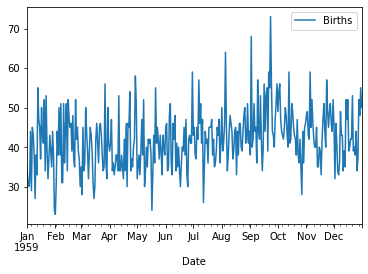

In [4]:
daily_biths = pd.read_csv('daily-total-female-births.csv', 
                 parse_dates=['Date'], index_col='Date')

daily_biths.head()

daily_biths.plot()

### Podział na część treningową i część testową

Ocena dokładności na podstawie tych samych danych, które były wykorzystane do konstrukcji prognozu, nie pozwala na w pełni wiarygodną ocenę skuteczności i może prowadzić do błędnych wniosków. Aby wiarygodnie porównać skuteczność różnych metod prognozowania, powinniśmy wykorzystać niezależne dane testowe.

W tym celu szereg dzielimy na:
- **część treningową** - wykorzystaną do dopasowania modelu i konstrukcji prognoz,
- **część testową** - wykorzystaną do oceny dokładności prognoz.

In [33]:
k = int(daily_biths.size * 0.8)

daily_biths_train = daily_biths[:k]
daily_biths_test = daily_biths[k:]

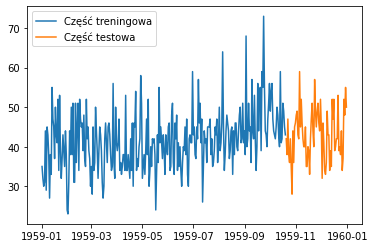

In [34]:
plt.plot(daily_biths_train, label="Część treningowa")
plt.plot(daily_biths_test, label="Część testowa")
plt.legend()
plt.show()

In [35]:
np.min(daily_biths_test.index), np.max(daily_biths_test.index)

(Timestamp('1959-10-20 00:00:00'), Timestamp('1959-12-31 00:00:00'))

In [36]:
arma42 = ARIMA(daily_biths_train, order=(7, 0, 0)).fit() #wybrany z analiz z poprzedniego zadania
arma42_predict = arma42.predict(start='1959-10-20', end='1959-12-31', dynamic=True)

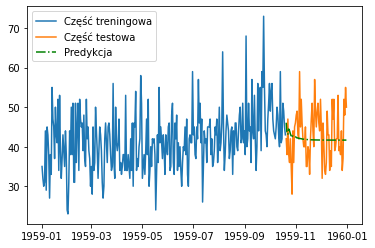

In [37]:
plt.plot(daily_biths_train, label="Część treningowa")
plt.plot(daily_biths_test, label="Część testowa")
plt.plot(arma42_predict, 'g-.', label="Predykcja")
plt.legend()
plt.show()

## Zadanie 1

Napisz funkcję, która znajdzie najlepszy model ARMA - pamiętaj o podziale zbioru na część treningową i testową.

In [38]:
def mse(y, yhat):
    return np.mean((y - yhat) ** 2)

def mae(y, yhat):
    return np.median(np.abs(y - yhat))

In [39]:
def find_the_best_arma(ts, max_p = 10, max_q=10, split=0.8):
    
    k = int(ts.size * split)
    ts_train = ts[:k]
    ts_test = ts[k:]

    aic = np.zeros((max_p, max_q))
    bic = np.zeros((max_p, max_q))
    mse2 = np.zeros((max_p, max_q))
    mae2 = np.zeros((max_p, max_q))
    
    for i in range(max_p):
        for j in range(max_q):
            try:
                arma = ARIMA(ts_train, order=(i + 1, 0, j + 1)).fit()
                aic[i, j] = arma.aic
                bic[i, j] = arma.bic
                print('ARMA(%d, %d): AIC=%f, BIC=%f' % (i+1, j+1, arma.aic, arma.bic))

                arma_pred = arma.predict(start=str(np.min(ts_test.index).year), end=str(np.max(ts_test.index).year), 
                                         dynamic=True)
                mse2[i, j] = mse(ts_test.values, arma_pred.values)
                mae2[i, j] = mae(ts_test.values, arma_pred.values)
            except:
                aic[i, j] = bic[i, j] = mse2[i, j] = mae2[i, j] = np.Inf
            
    print("-" * 30)
    min_aic = np.min(aic)
    min_arg_aic = np.argwhere(aic == min_aic)[0]
    print("MINIMUM AIC=%f dla p=%d, q=%d" % (min_aic, min_arg_aic[0] + 1, min_arg_aic[1] + 1))
    min_bic = np.min(bic)
    min_arg_bic = np.argwhere(bic == min_bic)[0]
    print("MINIMUM BIC=%f dla p=%d, q=%d" % (min_bic, min_arg_bic[0] + 1, min_arg_bic[1] + 1))
    
    min_mse = np.min(mse2)
    min_arg_mse = np.argwhere(mse2 == min_mse)[0]
    print("MINIMUM MSE=%f dla p=%d, q=%d" % (min_mse, min_arg_mse[0] + 1, min_arg_mse[1] + 1))
    
    min_mae = np.min(mae2)
    min_arg_mae = np.argwhere(mae2 == min_mae)[0]
    print("MINIMUM MAE=%f dla p=%d, q=%d" % (min_mae, min_arg_mae[0] + 1, min_arg_mae[1] + 1))

In [40]:
find_the_best_arma(daily_biths_train, 7, 7) #szukamy modelu o najlepszym AIC, BIC, MSE i MAE 
                                            #(te dwie ostatnie wyliczone na zbiorze walidacyjnym,
                                            #dzielimy wewnątrz funkcji zbiór daily_biths_train
                                            #na część na której uczymy i część która nam służy do policzenia
                                            #MSE lub MAE celem wyboru optymalnego p i q)
                                            #później zparoponowane przez te miary modele dopasowujemy na pełnym
                                            #daily_biths_train i patrzymy na predykcje na daily_biths_test

ARMA(1, 1): AIC=1567.873180, BIC=1581.677334
ARMA(1, 2): AIC=1569.586947, BIC=1586.842140
ARMA(1, 3): AIC=1571.185250, BIC=1591.891481
ARMA(1, 4): AIC=1573.014829, BIC=1597.172098
ARMA(1, 5): AIC=1574.290911, BIC=1601.899219
ARMA(1, 6): AIC=1575.308306, BIC=1606.367652
ARMA(1, 7): AIC=1575.248329, BIC=1609.758714
ARMA(2, 1): AIC=1569.684703, BIC=1586.939895
ARMA(2, 2): AIC=1562.404894, BIC=1583.111125
ARMA(2, 3): AIC=1564.166734, BIC=1588.324003
ARMA(2, 4): AIC=1568.412405, BIC=1596.020713
ARMA(2, 5): AIC=1570.952763, BIC=1602.012109
ARMA(2, 6): AIC=1573.009193, BIC=1607.519577
ARMA(2, 7): AIC=1571.140533, BIC=1609.101956
ARMA(3, 1): AIC=1571.039473, BIC=1591.745703
ARMA(3, 2): AIC=1564.226366, BIC=1588.383635
ARMA(3, 3): AIC=1566.390267, BIC=1593.998574
ARMA(3, 4): AIC=1568.134086, BIC=1599.193432
ARMA(3, 5): AIC=1572.357678, BIC=1606.868062
ARMA(3, 6): AIC=1574.840979, BIC=1612.802402
ARMA(3, 7): AIC=1572.252307, BIC=1613.664769
ARMA(4, 1): AIC=1572.851476, BIC=1597.008745
ARMA(4, 2)

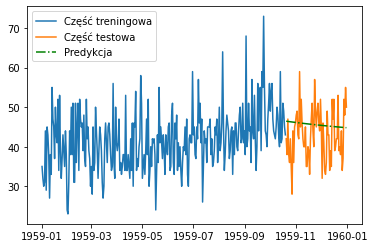

In [42]:
arma11 = ARIMA(daily_biths_train, order=(1, 0, 1)).fit()
arma11_predict = arma11.predict(start='1959-10-20', end='1959-12-31', dynamic=True)

plt.plot(daily_biths_train, label="Część treningowa")
plt.plot(daily_biths_test, label="Część testowa")
plt.plot(arma11_predict, 'g-.', label="Predykcja")
plt.legend()
plt.show()

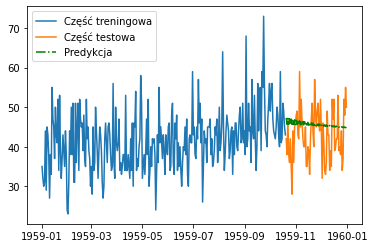

In [44]:
arma22 = ARIMA(daily_biths_train, order=(2, 0, 2)).fit()
arma22_predict = arma22.predict(start='1959-10-20', end='1959-12-31', dynamic=True)

plt.plot(daily_biths_train, label="Część treningowa")
plt.plot(daily_biths_test, label="Część testowa")
plt.plot(arma22_predict, 'g-.', label="Predykcja")
plt.legend()
plt.show()

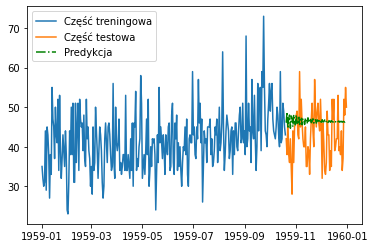

In [45]:
arma43 = ARIMA(daily_biths_train, order=(4, 0, 3)).fit()
arma43_predict = arma43.predict(start='1959-10-20', end='1959-12-31', dynamic=True)

plt.plot(daily_biths_train, label="Część treningowa")
plt.plot(daily_biths_test, label="Część testowa")
plt.plot(arma43_predict, 'g-.', label="Predykcja")
plt.legend()
plt.show()

In [ ]:
#najlepszy model wbrany przez BIC (nie ma dziwnych fluktuacji na początku) aczkolwiek można policzyć na części testowej MSE lub MAE

## Kroswalidacja

In [46]:
from sklearn.model_selection import TimeSeriesSplit

TRAIN: (0, 91)
TEST: (92, 182)


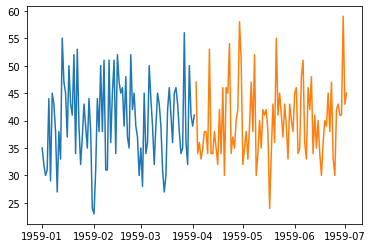

TRAIN: (0, 182)
TEST: (183, 273)


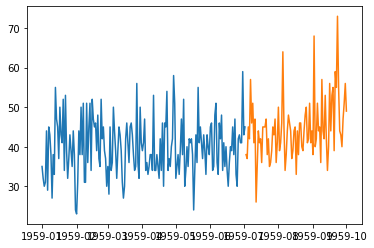

TRAIN: (0, 273)
TEST: (274, 364)


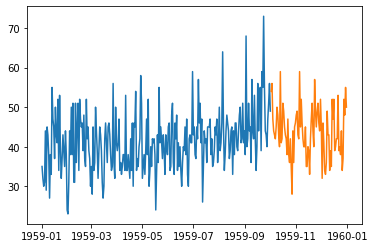

In [47]:
tscv = TimeSeriesSplit(n_splits=3)

for train_index, test_index in tscv.split(daily_biths.values):
    print("TRAIN: (%d, %d)" % (min(train_index), max(train_index)))
    print("TEST: (%d, %d)" % (min(test_index), max(test_index)))
    
    train, test = daily_biths.iloc[train_index], daily_biths.iloc[test_index]
    plt.plot(train)
    plt.plot(test)
    plt.show()

In [48]:
#kroswalidacja w szeregach czasowych wygląda nieco inaczej na początek bierzemy pierwszą jedną czwartą zbioru do uczenia i kolejną jedną czwartą do testowego
#następnie bierzemy pierwsze dwie czwarte zbioru do uczenia i kolejną jedną czwartą do testowego
#na koniec pierwsze trzy czwarte zbioru do uczenia i ostatnią jedną czwartą do testowego

## Zadanie 2

Napisz funkcję, która znajdzie najlepszy model ARMA - użyj kroswalidacji.

In [49]:
def find_the_best_arma_crossal(ts, max_p = 10, max_q=10, ar = False, cross=5):
    tscv = TimeSeriesSplit(n_splits=cross)
    
    aic = np.zeros((max_p + 1, max_q + 1))
    bic = np.zeros((max_p + 1, max_q + 1))
    mae_values = np.zeros((max_p + 1, max_q + 1))
    mse_values = np.zeros((max_p + 1, max_q + 1))
    
    for i in range(max_p + 1):
        for j in range(max_q + 1):
            if (i == j == 0):
                aic[0, 0] = bic[0, 0] = mae_values[0, 0] = mse_values[0, 0] = np.Inf
            elif (i == 0) | ((not ar) & (j == 0)):
                aic[i, j] = bic[i, j] = mae_values[i, j] = mse_values[i, j] = np.Inf
            else:
                aic_cross, bic_cross, mse_cross, mae_cross = [], [], [], []
                for train_index, test_index in tscv.split(ts.values):
                    train, test = ts.iloc[train_index], ts.iloc[test_index]
                    arma = ARIMA(train, order=(i, 0, j)).fit()
                    aic_cross.append(arma.aic)
                    bic_cross.append(arma.bic)
                    pred = arma.predict(start=str(np.min(test.index).year), end=str(np.max(test.index).year), dynamic=True)
                    mse_cross.append(mse(test.values, pred.values))
                    mae_cross.append(mae(test.values, pred.values))
                    
                aic[i, j] = np.mean(aic_cross)
                bic[i, j] = np.mean(arma.bic)
                mae_values[i, j] = np.nanmean(mae_cross)
                mse_values[i, j] = np.nanmean(mse_cross)
                print("ARMA(%d, %d): AIC=%f; BIC=%f; MSE=%f; MAE=%f" % (i, j, arma.aic, arma.bic, 
                                                                        mse_values[i, j], mae_values[i, j]))

    print("-" * 30)
    min_aic = np.nanmin(aic)
    min_arg_aic = np.argwhere(aic == min_aic)[0] 
    print("MINIMUM AIC=%f for p=%d, q=%d" % (min_aic, min_arg_aic[0], min_arg_aic[1]))
    
    min_bic = np.nanmin(bic)
    min_arg_bic = np.argwhere(bic == min_bic)[0] 
    print("MINIMUM BIC=%f for p=%d, q=%d" % (min_bic, min_arg_bic[0], min_arg_bic[1]))
    
    min_mse = np.nanmin(mse_values)
    min_arg_mse = np.argwhere(mse_values == min_mse)[0]
    print("MINIMUM MSE=%f for p=%d, q=%d" % (min_mse, min_arg_mse[0], min_arg_mse[1]))
    
    min_mae = np.nanmin(mae_values)
    min_arg_mae = np.argwhere(mae_values == min_mae)[0]
    print("MINIMUM MAE=%f for p=%d, q=%d" % (min_mae, min_arg_mae[0], min_arg_mae[1]))

In [50]:
k = int(daily_biths.size * 0.9)

daily_biths_train = daily_biths[:k]
daily_biths_test= daily_biths[k:]

find_the_best_arma_crossal(daily_biths_train, 7, 7, cross=4)
#Dzielimy zbiór na treningowy i testowy
#na treningowym robimy kroswalidację to znaczy w każdym obrocie pętli na części zbioru dopasowujemy model a na kolejnej części licząc na niej MSE, czy MAE sprawdzamy
#który z modeli jest najlepszy
#później użyjemy testowego, który nie był w kroswalidacji do sprawdzenia jakości predykcji 

ARMA(1, 1): AIC=1780.735023; BIC=1795.023639; MSE=55.426401; MAE=4.415679
ARMA(1, 2): AIC=1782.116084; BIC=1799.976854; MSE=55.479822; MAE=4.420545
ARMA(1, 3): AIC=1784.115204; BIC=1805.548128; MSE=55.565206; MAE=4.471023
ARMA(1, 4): AIC=1785.889567; BIC=1810.894645; MSE=55.394264; MAE=4.419502
ARMA(1, 5): AIC=1788.789649; BIC=1817.366881; MSE=56.234894; MAE=4.474594
ARMA(1, 6): AIC=1788.138369; BIC=1820.287756; MSE=56.625616; MAE=4.439089
ARMA(1, 7): AIC=1784.919984; BIC=1820.641525; MSE=56.569946; MAE=4.510608
ARMA(2, 1): AIC=1782.117193; BIC=1799.977964; MSE=55.480404; MAE=4.421402
ARMA(2, 2): AIC=1781.872729; BIC=1803.305653; MSE=55.448640; MAE=4.399236
ARMA(2, 3): AIC=1783.569961; BIC=1808.575039; MSE=55.483289; MAE=4.436540
ARMA(2, 4): AIC=1788.042525; BIC=1816.619757; MSE=55.205923; MAE=4.384675
ARMA(2, 5): AIC=1783.992743; BIC=1816.142129; MSE=56.226509; MAE=4.393082
ARMA(2, 6): AIC=1785.951890; BIC=1821.673430; MSE=56.436913; MAE=4.474319
ARMA(2, 7): AIC=1785.147993; BIC=1824.

In [51]:
np.min(daily_biths_test.index), np.max(daily_biths_test.index)

(Timestamp('1959-11-25 00:00:00'), Timestamp('1959-12-31 00:00:00'))

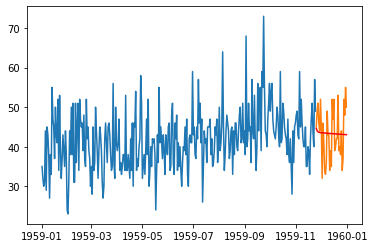

In [52]:
arma22 = ARIMA(daily_biths_train, order=(2, 0, 2)).fit()
pred22 = arma22.predict(start='1959-11-25', end='1959-12-31', dynamic=True)

plt.plot(daily_biths_train)
plt.plot(daily_biths_test)
plt.plot(pred22, 'r-')
plt.show()

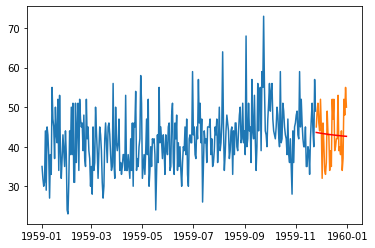

In [53]:
arma11 = ARIMA(daily_biths_train, order=(1, 0, 1)).fit()
pred11 = arma11.predict(start='1959-11-25', end='1959-12-31', dynamic=True)

plt.plot(daily_biths_train)
plt.plot(daily_biths_test)
plt.plot(pred11, 'r-')
plt.show()

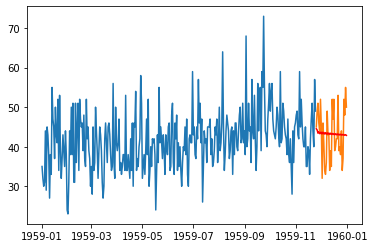

In [54]:
arma42 = ARIMA(daily_biths_train, order=(4, 0, 2)).fit()
pred42 = arma42.predict(start='1959-11-25', end='1959-12-31', dynamic=True)

plt.plot(daily_biths_train)
plt.plot(daily_biths_test)
plt.plot(pred42, 'r-')
plt.show()

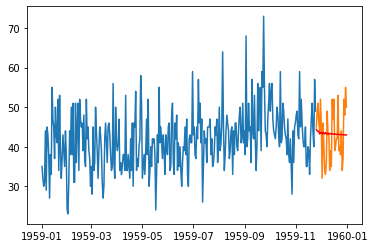

In [55]:
arma63 = ARIMA(daily_biths_train, order=(6, 0, 3)).fit()
pred63 = arma63.predict(start='1959-11-25', end='1959-12-31', dynamic=True)

plt.plot(daily_biths_train)
plt.plot(daily_biths_test)
plt.plot(pred63, 'r-')
plt.show()

In [ ]:
#najlepszy model BIC

# Predykcja z wykorzystaniem danych historycznych

In [ ]:
#tutaj tworzymy predykcję dla obserwacji na podstawie struktury opisanej w modelu i konkretnych danych, które mają wcześniejsze indeksy czasowe
#w kolejnym kroku nie bierzemy predykcji, którą uzyskaliśmy dla wcześniejszej obserwacji, tylko prawdziwą wartość szeregu 

In [56]:
history = daily_biths_train.values.tolist()
prediction = []
simple_prediction = []
errors = []
test = daily_biths_test.values

for t in range(len(test)):
    model = ARIMA(history, order=(7, 0, 0)).fit()
    pred = model.forecast()[0]
    prediction.append(pred)
    simple_prediction.append(history[-1][0])
    history.append(test[t])
    
    errors.append((pred - test[t])**2)

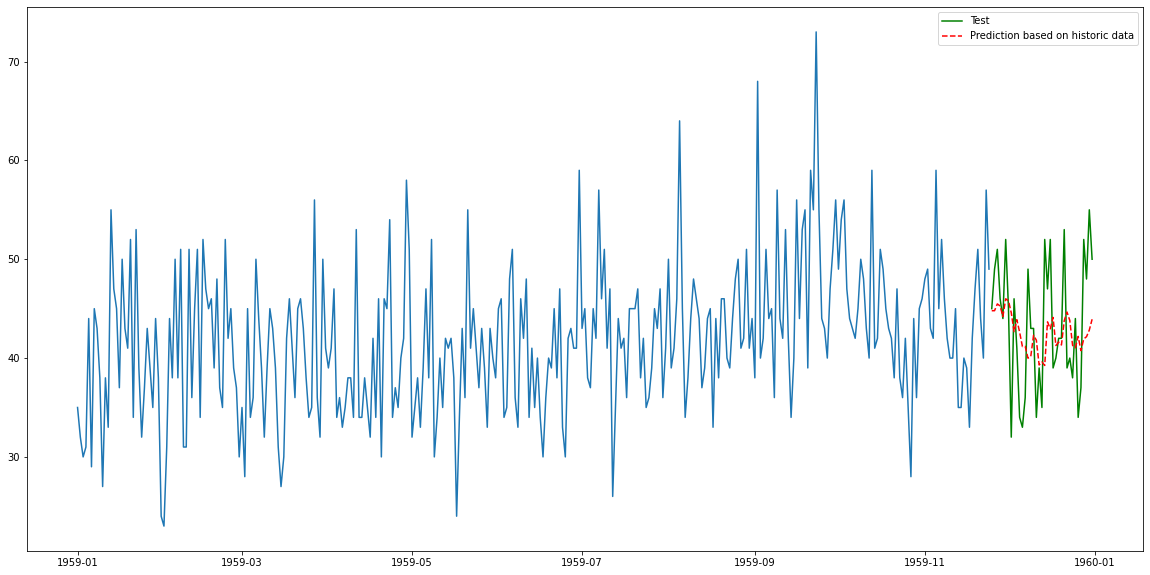

In [57]:
plt.figure(figsize=(20, 10))

plt.plot(daily_biths_train)
plt.plot(daily_biths_test, 'g-', label="Test")
plt.plot(pd.Series(prediction, index=daily_biths_test.index), 'r--', label="Prediction based on historic data")
#plt.plot(pd.Series(simple_prediction, index=sunspots_test.index), 'm.-', label="Naive prediction") #naiwna predykcja to wzięcie po prostu 
#wcześniejszej obserwacji jako predykcji następnej
plt.legend()
plt.show()